# **Predictive modeling** with Object-Oriented Programming

> AbbVie: Patient's Condition to Condition Prediction


In [ ]:
#!pip install consort
#!pip install collections
# Import required packages
from consort import ConsortGraph
from matplotlib.lines import Line2D
from scipy.stats import chi2_contingency
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import sklearn
from sklearn.preprocessing import LabelEncoder
import networkx as nx
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from matplotlib.pylab import rcParams
from itertools import combinations
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
# Object-Oriented Programming
class PredictaVie_Preprocess:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def event_pie_chart(self, column_name):
        counts = self.dataframe[column_name].value_counts()
        total_count = counts.sum()
        ratios = counts / total_count
        significant_events = ratios[ratios >= 0.01]
        other_ratio = ratios[ratios < 0.01].sum()
        significant_events['others'] = other_ratio
        plt.figure(figsize=(8, 6))
        plt.pie(significant_events, labels=significant_events.index, autopct='%1.1f%%', startangle=140)
        plt.title('Distribution of ' + column_name + ' in the target dataset:')
        plt.show()

    def ind_event_sequence(self, person_id):
        df = self.dataframe
        df['event_date'] = pd.to_datetime(df['event_date'])
        df0 = df[df['person_id'] == person_id]
        df1 = df0.sort_values(by='event_date')
        df2 = df1[df1['event'] != df1['event'].shift(-1)]
        df2.reset_index(drop=True, inplace=True)
        return df2

    def plot_journey(self, person_id):
        df = self.dataframe
        df['event_date'] = pd.to_datetime(df['event_date'])
        person_data = df[df['person_id'] == person_id]
        person_data_sorted = person_data.sort_values(by='event_date')
        person_data_unique = person_data_sorted[person_data_sorted['event'] != person_data_sorted['event'].shift(-1)]
        person_data_unique.reset_index(drop=True, inplace=True)
        G = nx.DiGraph()
        for _, row in person_data_unique.iterrows():
            G.add_node(row['event'])
        for i in range(len(person_data_unique) - 1):
            current_event = person_data_unique.iloc[i]['event']
            next_event = person_data_unique.iloc[i + 1]['event']
            G.add_edge(current_event, next_event)
        pos = nx.circular_layout(G)
        nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=7, font_weight='bold',
                arrows=True, arrowsize=20)
        plt.title('Event Sequence for Person ID: ' + str(person_id))
        plt.show()

    def create_event_sequence(self):
        event_sequence_df = pd.DataFrame(columns=['person_id', 'gender'])
        last_event_df = pd.DataFrame(columns=['person_id'])
        for person_id, group in self.dataframe.groupby('person_id'):
            gender = group['gender'].iloc[0]
            events = group.sort_values(by='event_date')['event'].tolist()
            previous_event = None
            event_list = []
            for event in events:
                if event != previous_event:
                    event_list.append(event)
                previous_event = event
            event_sequence = {'person_id': person_id, 'gender': gender}
            sequence_count = 0
            for i in event_list[:-1]:
                sequence_count += 1
                event_sequence[f'condition_{sequence_count}'] = i
            event_sequence_df = pd.concat([event_sequence_df, pd.DataFrame(event_sequence, index=[0])],
                                          ignore_index=True)
            last_event_df = pd.concat([last_event_df, pd.DataFrame({'person_id': [person_id],
                                                                    'last_condition': [event_list[-1]]})],
                                      ignore_index=True)
        all_together = pd.merge(event_sequence_df, last_event_df, on='person_id', how='inner')
        self.event_sequence = all_together
        return all_together

    def filter_long_journey(self, top_numbers=2000):
        if not hasattr(self, 'event_sequence'):
            raise AttributeError("The 'event_sequence' attribute has not been generated. Please call 'create_event_sequence' method first.")

        data = self.event_sequence
        data['null_count'] = data.isnull().sum(axis=1)
        sort = data.sort_values(by='null_count', ascending=True)
        sort.reset_index(drop=True, inplace=True)
        result = sort.iloc[:, :-1].head(top_numbers)
        self.long_journey = result
        return result

    def generate_pairs(self):
        if not hasattr(self, 'long_journey'):
            raise AttributeError("The 'long_journey' attribute has not been generated. Please call 'filter_long_journey' method first.")

        df = self.long_journey
        pairs = []
        for index, row in df.iterrows():
            person_id = row['person_id']
            gender = row['gender']
            last = row['last_condition']
            conditions = [col for col in row['condition_1':'last_condition'] if pd.notnull(col)]

            for pair in combinations(conditions, 2):
                if pair[0] != pair[1]:  # avoid having same conditions paired
                    pairs.append({'person_id': person_id, 'gender': gender, 'pair': ' -> '.join(pair),
                                  'last_condition': last})

        pairs_df = pd.DataFrame(pairs)
        self.pairs = pairs_df
        return pairs_df

    def pairs_to_bin(self):
        if not hasattr(self, 'pairs'):
            raise AttributeError("The 'pairs' attribute has not been generated. Please call 'generate_pairs' method first.")

        df = self.pairs
        pair_type = df['pair'].unique()
        pair_bin_df = pd.DataFrame(columns=['person_id', 'MALE', 'FEMALE'] + list(pair_type))

        for person_id, group in df.groupby('person_id'):
            gender = group['gender'].iloc[0]
            last = group['last_condition'].iloc[0]
            pair_bin = {'person_id': person_id, 'last_condition': last}

            for i in ['MALE', 'FEMALE']:
                pair_bin[i] = 0
                if i == gender:
                    pair_bin[i] = 1

            for i in pair_type:
                pair_bin[i] = 0
                if i in group['pair'].values:
                    pair_bin[i] = 1

            pair_bin_df = pd.concat([pair_bin_df, pd.DataFrame(pair_bin, index=[0])], ignore_index=True)

        return pair_bin_df

    def pairs_to_count(self):
        if not hasattr(self, 'pairs'):
            raise AttributeError("The 'pairs' attribute has not been generated. Please call 'generate_pairs' method first.")

        df = self.pairs
        pair_types = df['pair'].unique()
        pair_count_df = pd.DataFrame(columns=['person_id', 'MALE', 'FEMALE'] + list(pair_types))

        for person_id, group in df.groupby('person_id'):
            gender = group['gender'].iloc[0]
            last = group['last_condition'].iloc[0]

            pair_counts = group['pair'].value_counts().to_dict()

            pair_count = {'person_id': person_id, 'last_condition': last}

            for i in ['MALE', 'FEMALE']:
                pair_count[i] = 0
                if i == gender:
                    pair_count[i] = 1

            for pair_type in pair_types:
                pair_count[pair_type] = pair_counts.get(pair_type, 0)

            pair_count_df = pd.concat([pair_count_df, pd.DataFrame([pair_count])], ignore_index=True)

        return pair_count_df

class PredictaVie_SplitData:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def c2c_split_data(self, test_size=0.2, random_state=42):
        df = self.dataframe
        exclude_column = ['person_id', 'last_condition']
        filtered_columns = [col for col in df.columns if col not in exclude_column]
        y = df['last_condition']
        x = df.loc[:, filtered_columns].astype(int)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
        return x_train, x_test, y_train, y_test

class PredictaVie_Model:
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

    def c2c_train_xgb(self, param_grid=None, cv=5):
        label_encoder = LabelEncoder()
        y_train_encoded = label_encoder.fit_transform(self.y_train)

        if param_grid is None:
            param_grid = {
                'n_estimators': [100, 150, 200],
                'max_depth': [3, 4, 5],
                'learning_rate': [0.1, 0.01, 0.001]
            }

        model = xgb.XGBClassifier()
        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy')
        grid_search.fit(self.x_train, y_train_encoded)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        print("Best parameters:", best_params)
        print("Best cross-validation accuracy:", best_score)

        self.best_xgbmodel = best_model

        return best_model

    def c2c_evaluate_xgb(self):
        if not hasattr(self, 'best_xgbmodel'):
            raise AttributeError("The 'best_xgbmodel' has not been generated. Please call 'c2c_train_xgb' method first.")

        best = self.best_xgbmodel

        label_encoder = LabelEncoder()
        y_test_encoded = label_encoder.fit_transform(self.y_test)

        y_pred = best.predict(self.x_test)

        accuracy = accuracy_score(y_test_encoded, y_pred)
        print("Test Accuracy:", accuracy)

        original_labels = label_encoder.inverse_transform(y_test_encoded)
        predicted_labels = label_encoder.inverse_transform(y_pred)
        cm = confusion_matrix(original_labels, predicted_labels)

        cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_df, annot=True, cmap="YlGnBu", fmt="d")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def c2c_xgb_feature_importance(self):
        if not hasattr(self, 'best_xgbmodel'):
            raise AttributeError("The 'best_xgbmodel' has not been generated. Please call 'c2c_train_xgb' method first.")

        xgb_model = self.best_xgbmodel
        feature_importance = xgb_model.feature_importances_
        feature_names = xgb_model.get_booster().feature_names
        feature_importance_dict = dict(zip(feature_names, feature_importance))
        sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

        features = [x[0] for x in sorted_feature_importance]
        importance = [x[1] for x in sorted_feature_importance]

        plt.figure(figsize=(10, 15))
        plt.barh(features, importance, color='skyblue')
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title('XGBoost Feature Importance')
        plt.gca().invert_yaxis()
        plt.show()
        top_20_feature_indices = [item[0] for item in sorted_feature_importance[:20]]
        return top_20_feature_indices

    def c2c_train_logreg(self, param_grid=None):
        logistic_reg = LogisticRegression()

        if param_grid is None:
            param_grid = {
                'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
            }

        grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=5, scoring='accuracy')
        grid_search.fit(self.x_train, self.y_train)
        print("Best Parameters:", grid_search.best_params_)

        best_model = grid_search.best_estimator_

        feature_names = list(self.x_train.columns)
        feature_weights = best_model.coef_[0]
        feature_weight_dict = dict(zip(feature_names, feature_weights))
        print("\nFeature Weights in the Best Model:")
        for feature, weight in feature_weight_dict.items():
            print(f"{feature}: {weight}")

        abs_feature_weights = np.abs(feature_weights)
        top_20_indices = np.argsort(abs_feature_weights)[::-1][:20]
        top_20_features = [feature_names[i] for i in top_20_indices]

        self.best_logregmodel = best_model

        return best_model, top_20_features

    def c2c_evaluate_logreg(self):
        if not hasattr(self, 'best_logregmodel'):
            raise AttributeError("The 'best_logregmodel' has not been generated. Please call 'c2c_train_logreg' method first.")

        best = self.best_logregmodel

        y_pred = best.predict(self.x_test)

        accuracy = accuracy_score(self.y_test, y_pred)
        print("Test Accuracy:", accuracy)

        cm = confusion_matrix(self.y_test, y_pred)
        cm_df = pd.DataFrame(cm, index=best.classes_, columns=best.classes_)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='g')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix Heatmap')
        plt.show()


In [ ]:
# load the data
from dbconns import ImpalaConnector # AbbVie's package
ic = ImpalaConnector('---','---', connection = "---") # I deleted those sensity information here and replaced them with '---'
# app_rwd_capstone_group3.data_kidney is from the SQL dataset
data_kidney = ic.read("SELECT * FROM app_rwd_capstone_group3.data_kidney ORDER BY person_id LIMIT 300000")
data_kidney.head()

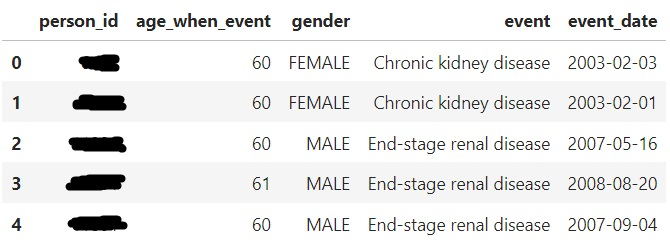

In [7]:
# result display
from IPython.display import Image
Image(filename='/content/螢幕擷取畫面 2024-04-06 165717.jpg')

In [ ]:
# load the preprocess package
preprocess = PredictaVie_Preprocess(data_kidney)

In [ ]:
# shoe the distribution of each events in the dataset
preprocess.event_pie_chart('event')

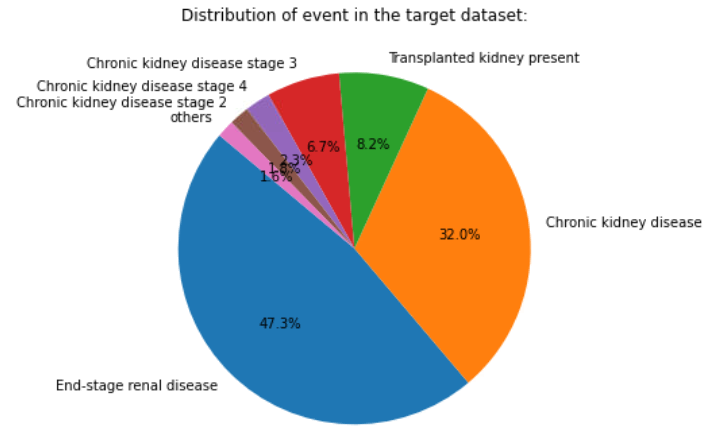

In [8]:
# result display
Image(filename='/content/螢幕擷取畫面 2024-04-06 170044.png')

In [ ]:
# take one patient as an example
preprocess.ind_event_sequence(11801)

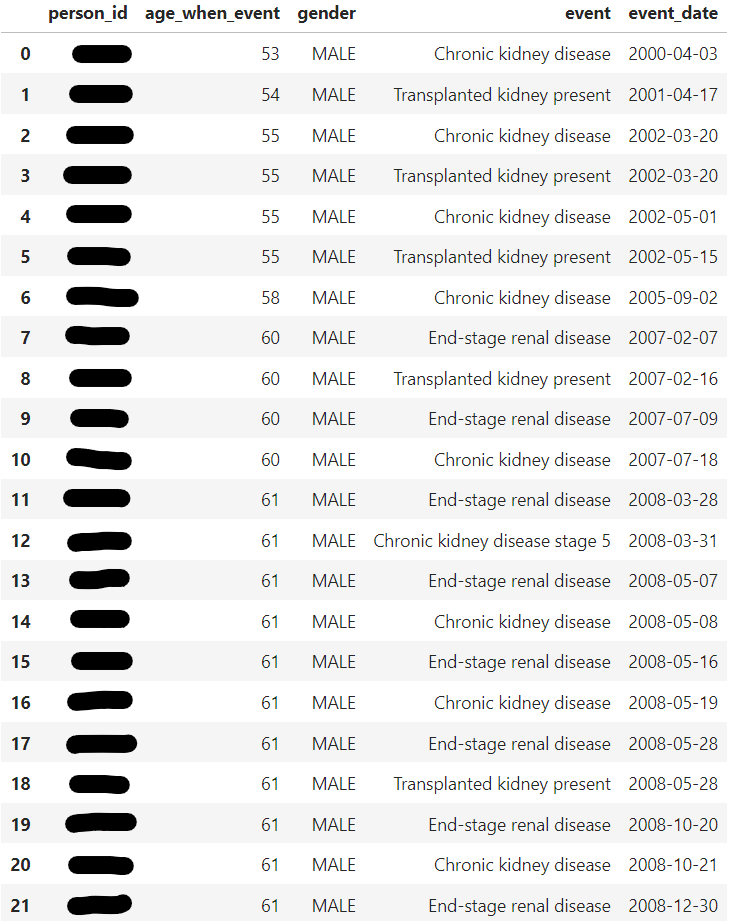

In [10]:
# result display
Image(filename='/content/螢幕擷取畫面 2024-04-06 170302.png')

In [ ]:
# the pateint's condition journey
preprocess.plot_journey(0001)

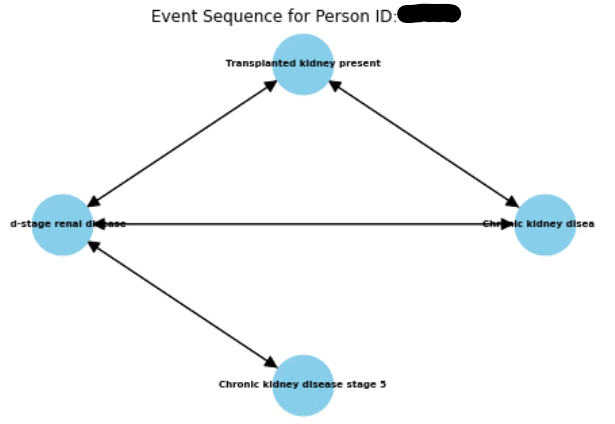

In [11]:
# result display
Image(filename='/content/螢幕擷取畫面 2024-04-06 170610.png')

In [ ]:
# create the condition sequence
preprocess.create_event_sequence()

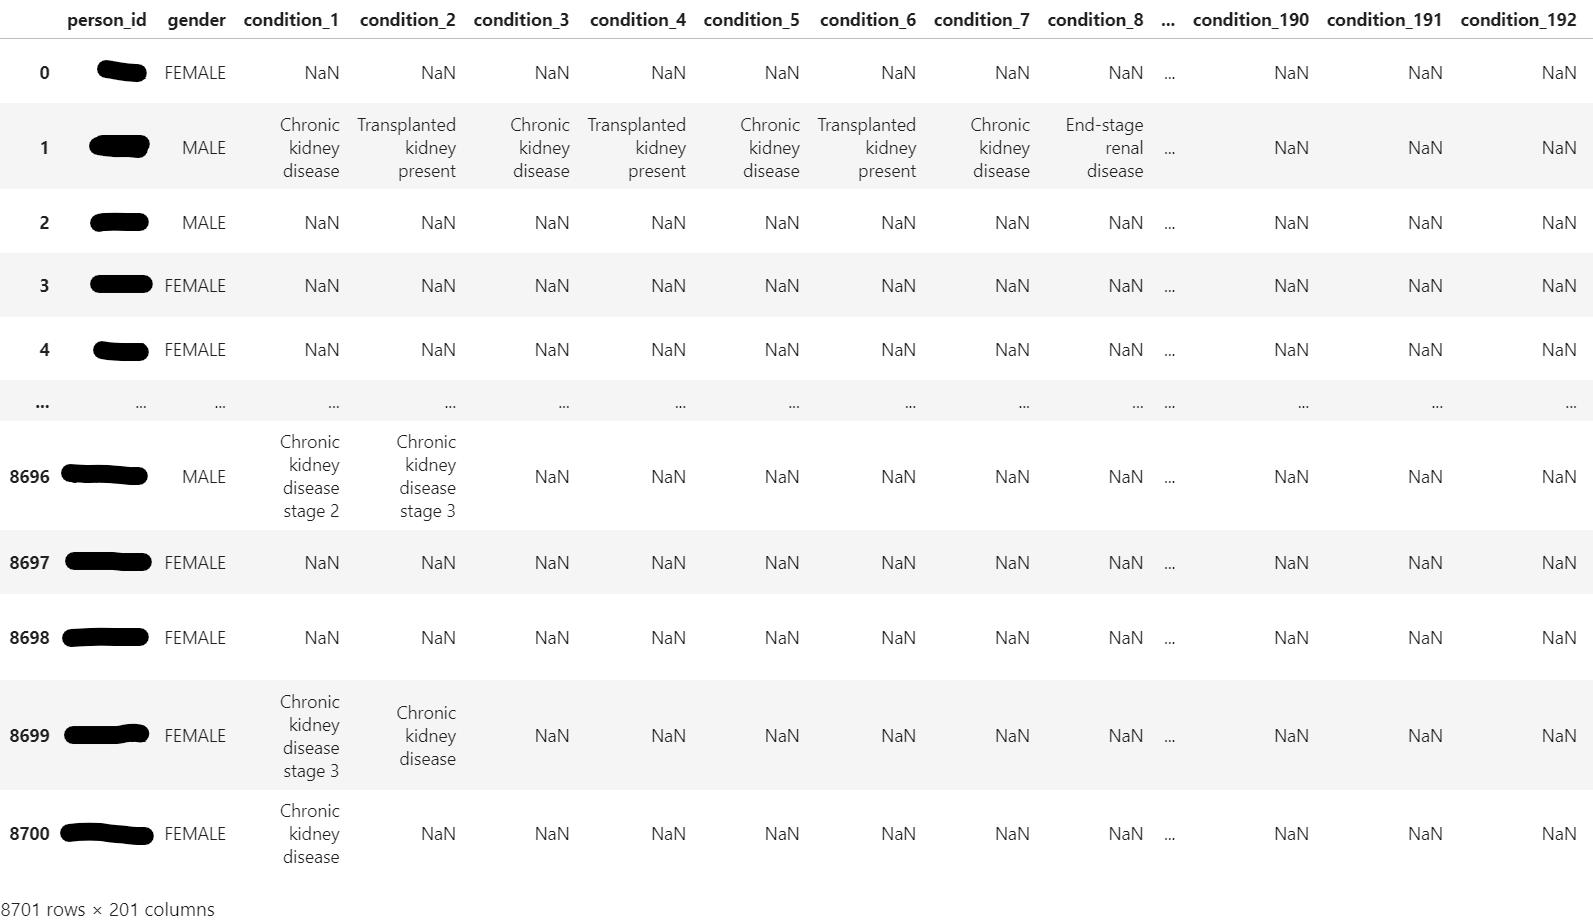

In [12]:
# result display
Image(filename='/content/螢幕擷取畫面 2024-04-06 170736.png')

In [ ]:
# take the top 2000 patients who have long condition journey (lots of event histories)
preprocess.filter_long_journey()

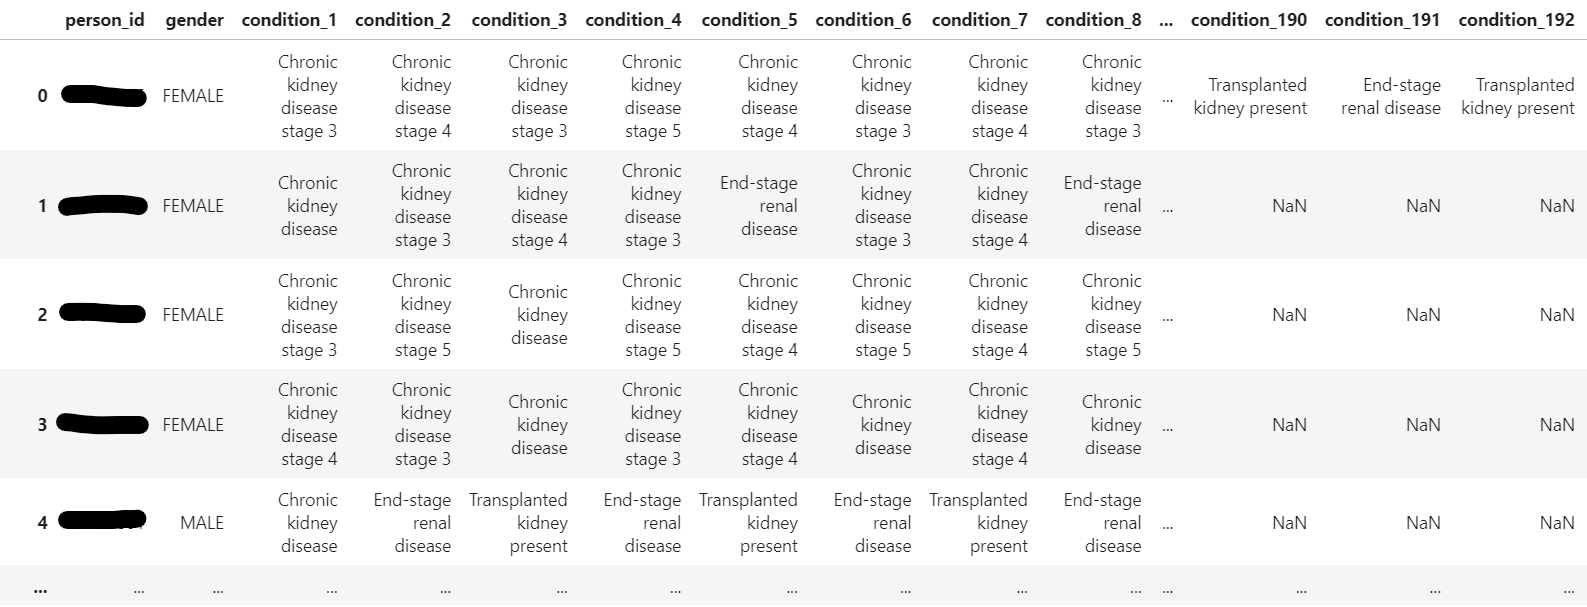

In [13]:
# result display
Image(filename='/content/螢幕擷取畫面 2024-04-06 170915.png')

In [ ]:
# create condition pairs on the filtered data (including duplicated pairs)
preprocess.generate_pairs()

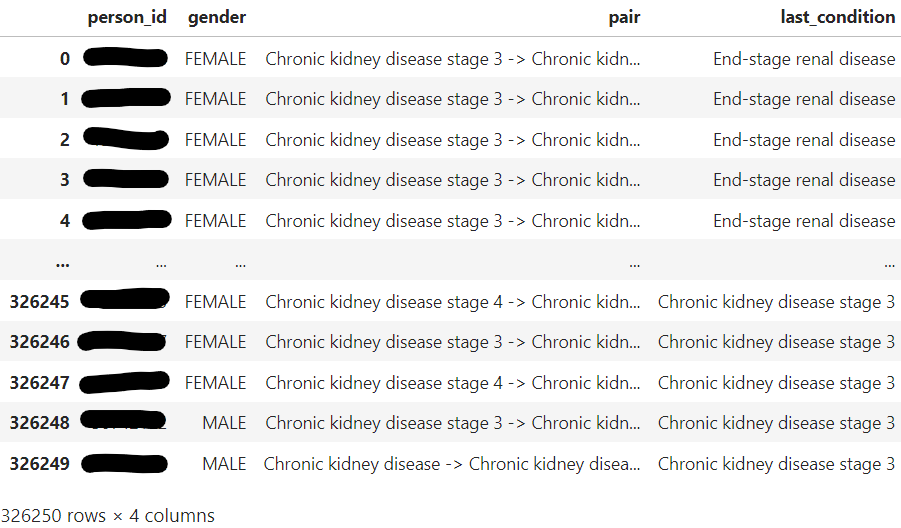

In [14]:
# result display
Image(filename='/content/螢幕擷取畫面 2024-04-06 171019.png')

In [ ]:
# make the condition pairs into count
paircount = preprocess.pairs_to_count()
paircount

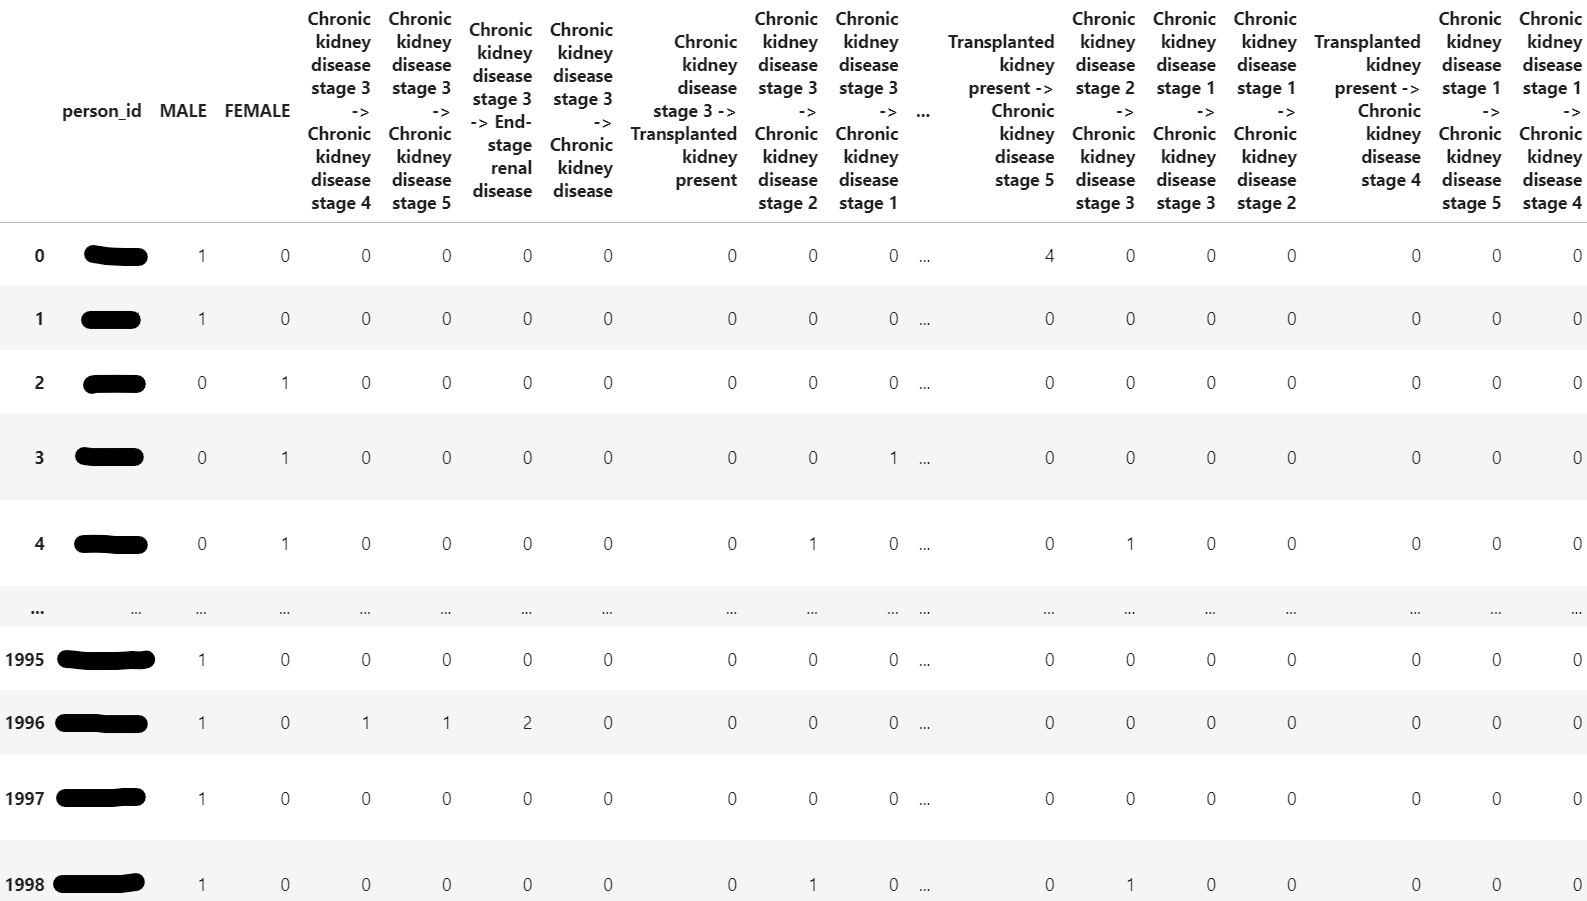

In [15]:
# result display
Image(filename='/content/螢幕擷取畫面 2024-04-06 171144.png')

In [ ]:
# make the condition pairs into binary
pairbin = preprocess.pairs_to_bin()
pairbin

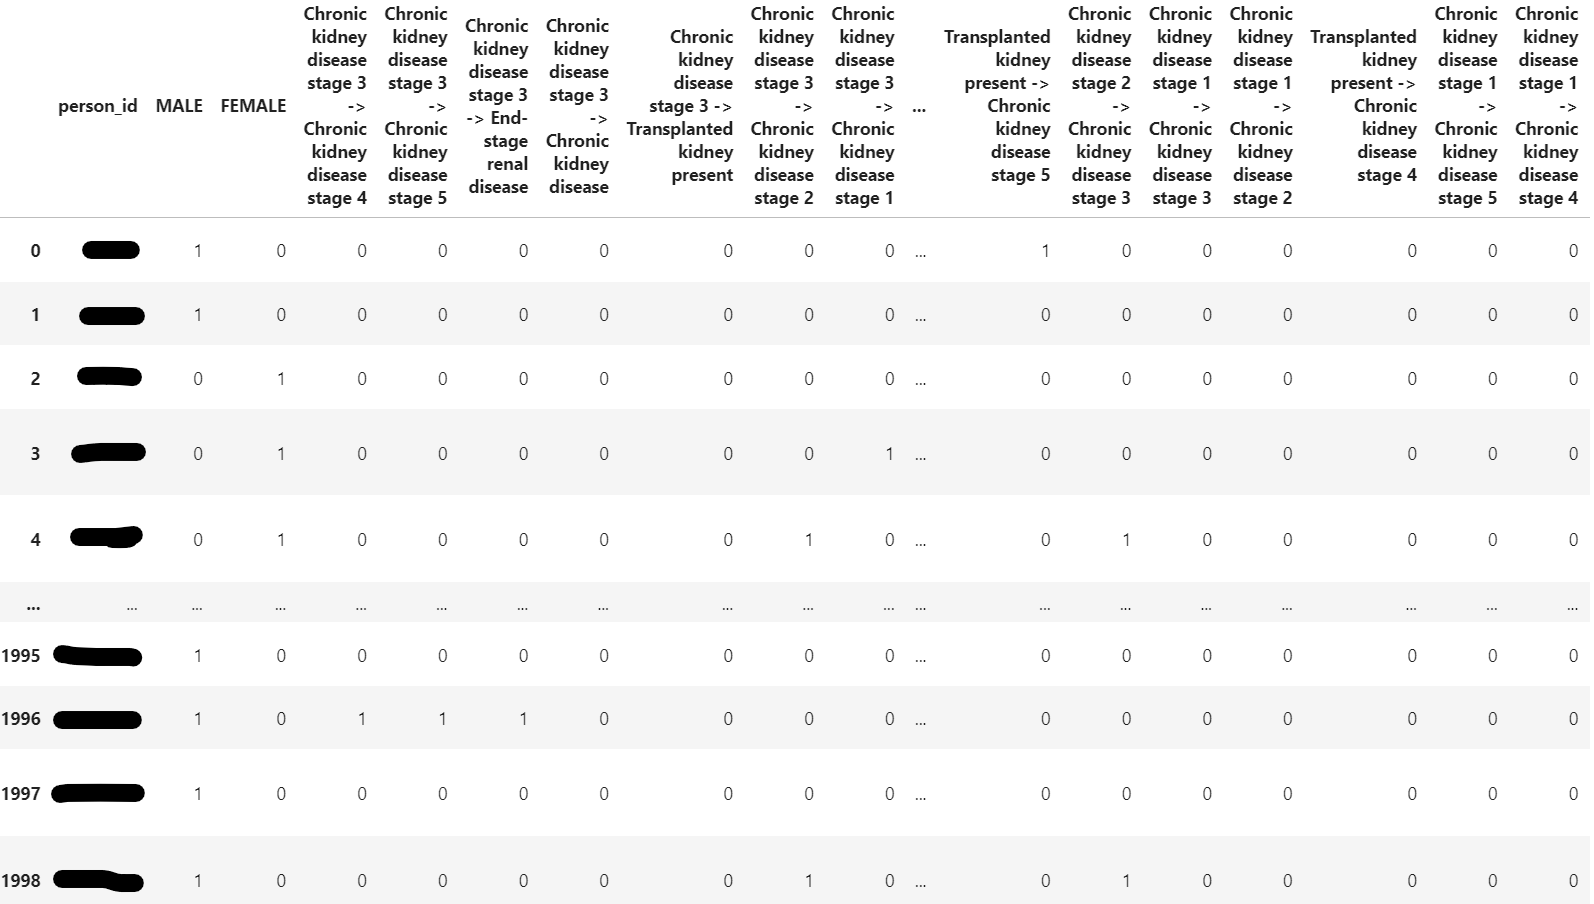

In [16]:
# result display
Image(filename='/content/螢幕擷取畫面 2024-04-06 171354.png')

In [ ]:
# load the train_test_split package
paircountsplit = PredictaVie_SplitData(paircount)
pairbinsplit = PredictaVie_SplitData(pairbin)

In [ ]:
# Split data into training and testing, respectively
x_train, x_test, y_train, y_test = paircountsplit.c2c_split_data() # for count data
X_train, X_test, Y_train, Y_test = pairbinsplit.c2c_split_data() # for binary data

In [ ]:
# load the model package
countmodel = PredictaVie_Model(x_train, y_train, x_test, y_test)
binmodel = PredictaVie_Model(X_train, Y_train, X_test, Y_test)

In [ ]:
# Use Gridsearch to build and find the best XGBoost model
binmodel.c2c_train_xgb()

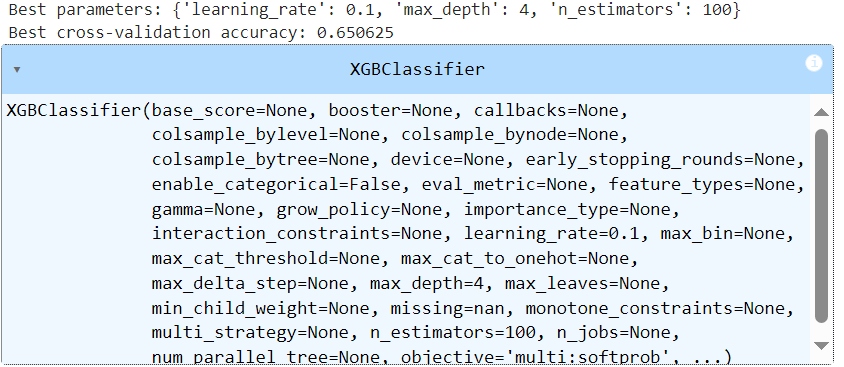

In [17]:
# result display
Image(filename='/content/螢幕擷取畫面 2024-04-06 171627.png')

In [ ]:
# test the best XGBoost model to see its performance
binmodel.c2c_evaluate_xgb()

# not quite good since it only performs well in predicting CKD satge 3, ESRD, and TKP
# (CKD stage 2 identified as CKD stage 3 seems not be a big problem so take it)

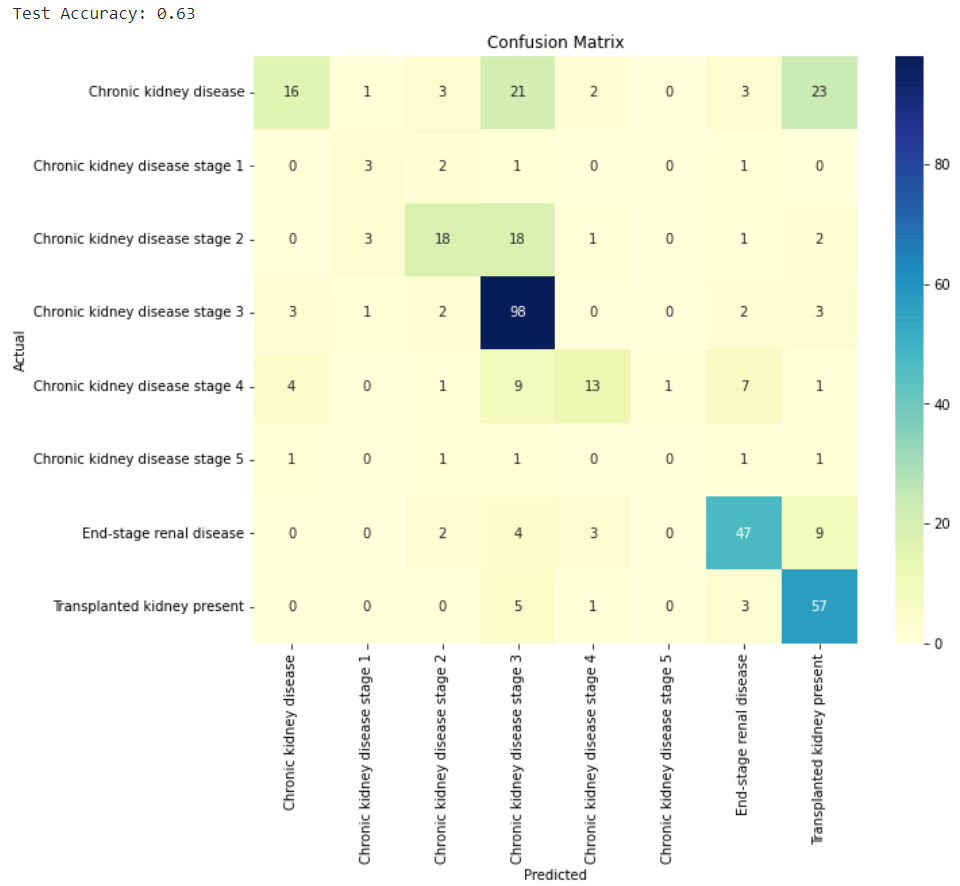

In [18]:
# result display
Image(filename='/content/螢幕擷取畫面 2024-04-06 171733.png')

In [ ]:
# Check which condtion pairs are important for predictions
xgb_top_features = binmodel.c2c_xgb_feature_importance()
xgb_top_features # store the top 20 important features into a list

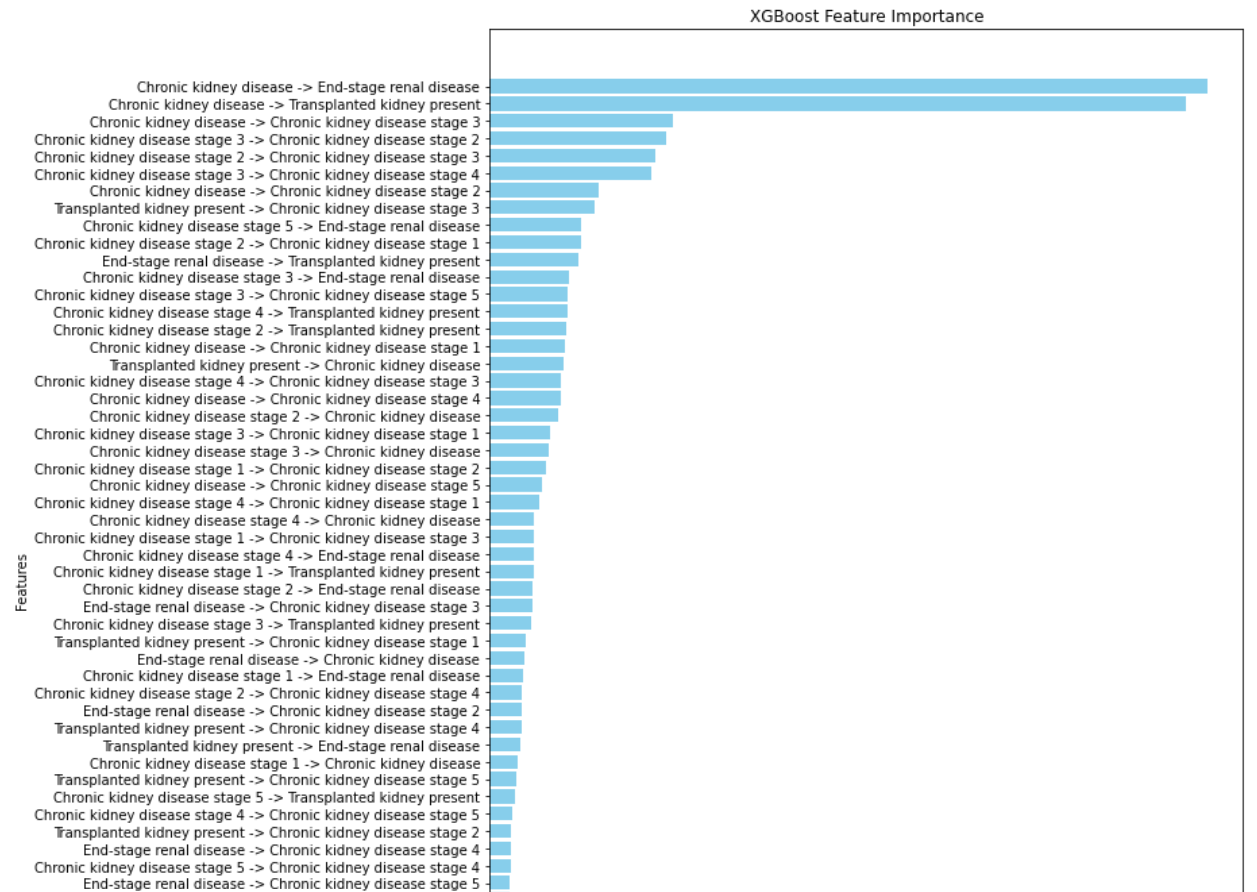

In [22]:
# result display
Image(filename='/content/螢幕擷取畫面 2024-04-06 174218.png')

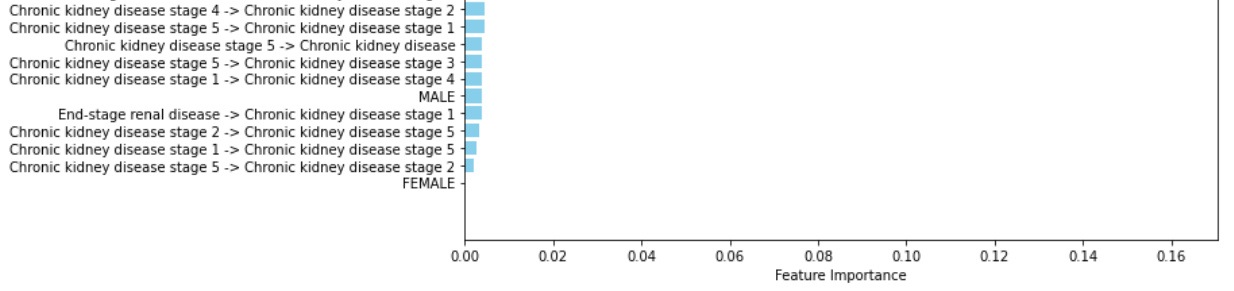

In [23]:
# result display
Image(filename='/content/螢幕擷取畫面 2024-04-06 174246.png')

In [ ]:
# ignore "convergence not found" warnings while the gridsearch is running
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Use Gridsearch to build and find the best Logistic Regression model
_, logreg_top_features = countmodel.c2c_train_logreg()
logreg_top_features # store the top 20 important features into a list

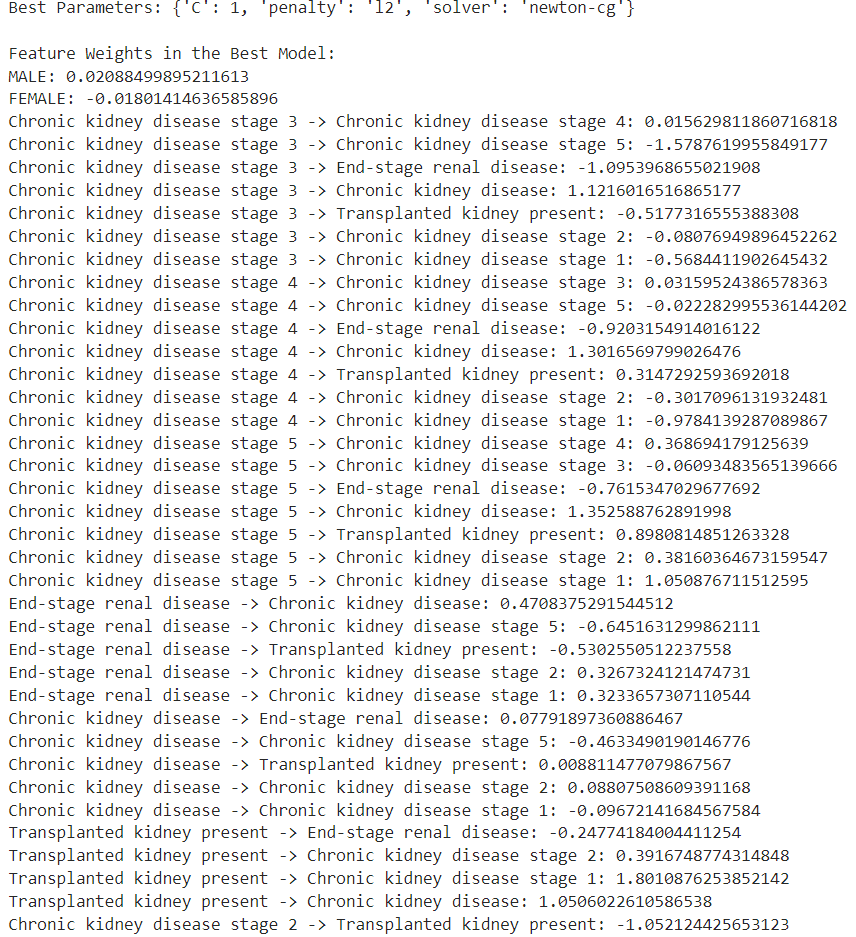

In [19]:
# result display
Image(filename='/content/螢幕擷取畫面 2024-04-06 171918.png')

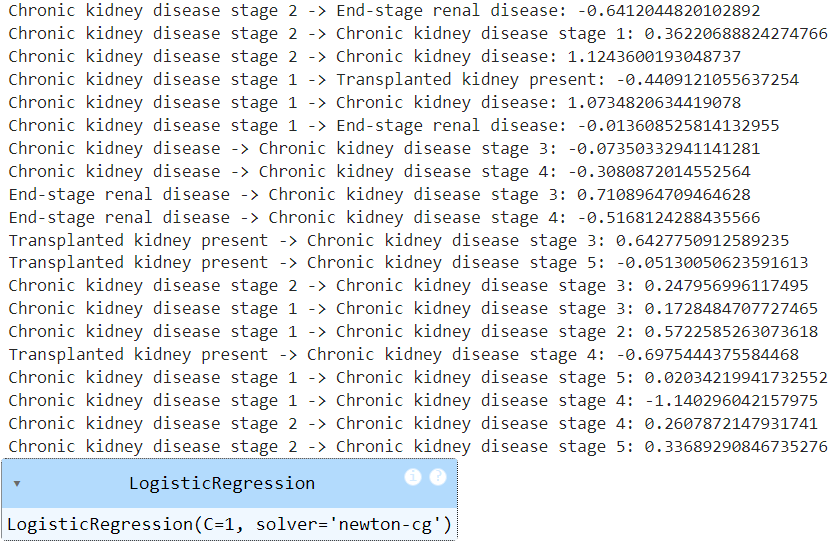

In [20]:
# result display (continued)
Image(filename='/content/螢幕擷取畫面 2024-04-06 171952.png')

In [ ]:
# test the best XGBoost model to see its performance
countmodel.c2c_evaluate_logreg()

# better than XGBoost!
# performs well in predicting:
# CKD, CKD stage 2 (though some were predicted as CKD satge 3, predicting worse condition may be acceptable), CKD satge 3, CKD stage 4, ESRD, and TKP

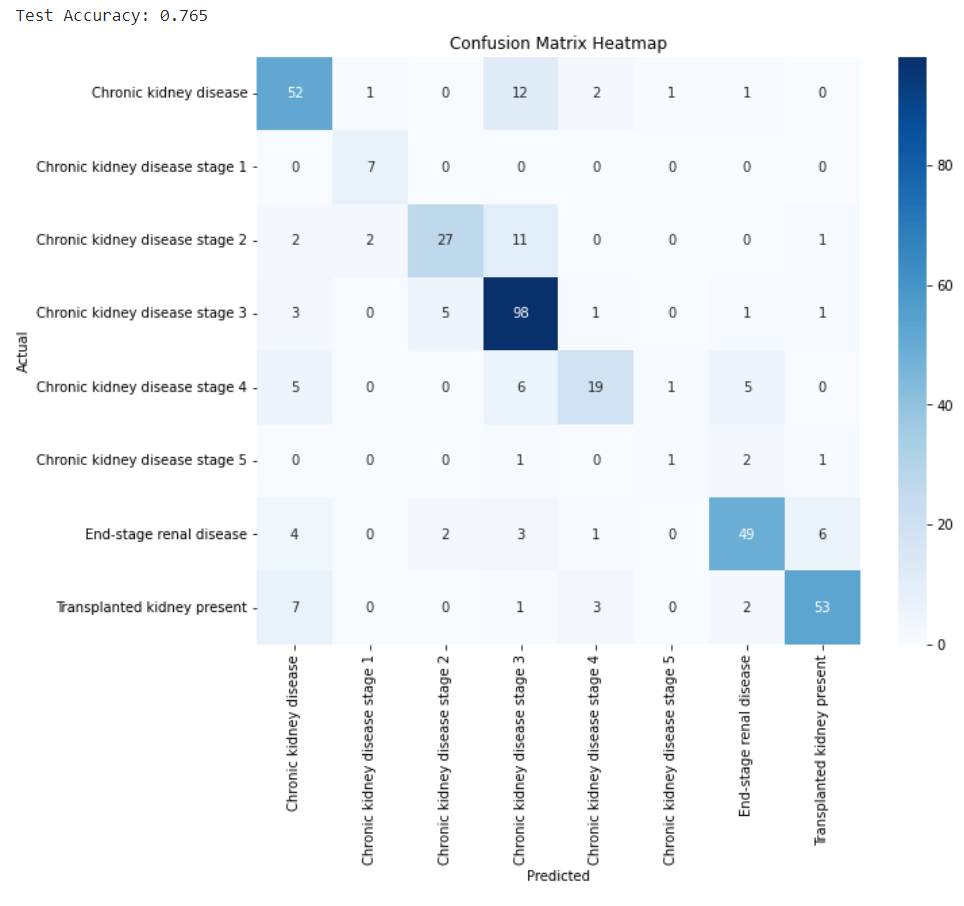

In [21]:
# result display (continued)
Image(filename='/content/螢幕擷取畫面 2024-04-06 172113.png')

## >> Will use Logistic Regression Model to make condition to condition predcition (for this dataset)!
## * XGBoost Model may be used on other datasets

In [ ]:
# try using less columns (focus on the top condition pairs)
paircountsplit = PredictaVie_SplitData(paircount[['person_id', 'MALE', 'FEMALE', 'last_condition'] + logreg_top_features])
pairbinsplit = PredictaVie_SplitData(pairbin[['person_id', 'MALE', 'FEMALE', 'last_condition'] + xgb_top_features])

# Split data
x_train, x_test, y_train, y_test = paircountsplit.c2c_split_data() # for count data
X_train, X_test, Y_train, Y_test = pairbinsplit.c2c_split_data() # for binary data

# load the model package
countmodel = PredictaVie_Model(x_train, y_train, x_test, y_test)
binmodel = PredictaVie_Model(X_train, Y_train, X_test, Y_test)

In [ ]:
# Use Gridsearch to build and find the best XGBoost model
binmodel.c2c_train_xgb()

# test the best XGBoost model to see its performance
binmodel.c2c_evaluate_xgb()

# the performance seems to be a bit worse... (using the top features)

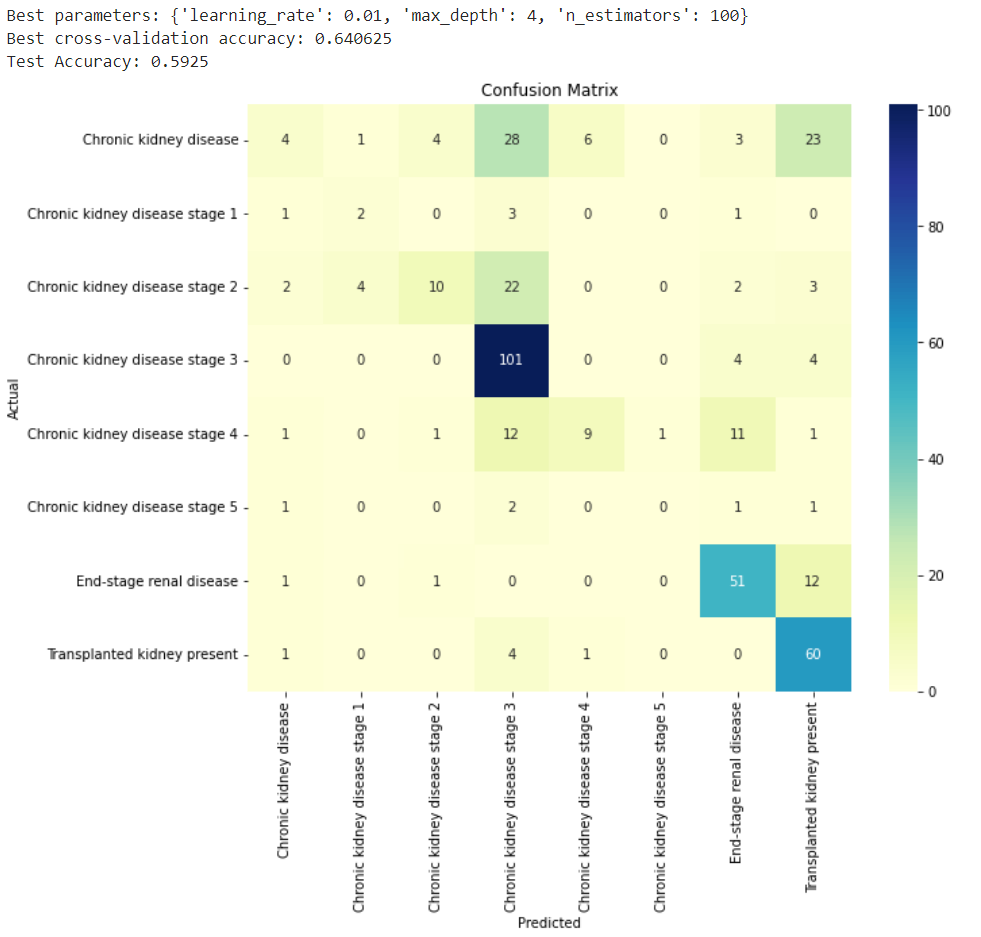

In [24]:
# result display (continued)
Image(filename='/content/螢幕擷取畫面 2024-04-06 183809.png')

In [ ]:
# Use Gridsearch to build and find the best Logistic Regression model
countmodel.c2c_train_logreg()

# test the best Logistic Regression model to see its performance
countmodel.c2c_evaluate_logreg()

# Focusing on the top features makes the Logistic Regression Terrible! Don't do it!

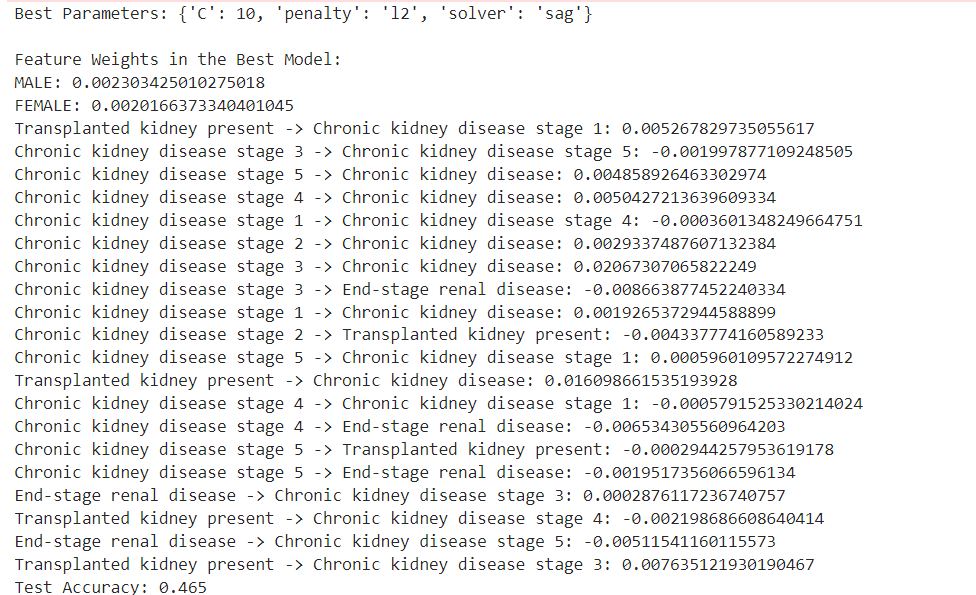

In [25]:
# result display (continued)
Image(filename='/content/螢幕擷取畫面 2024-04-06 183923.png')

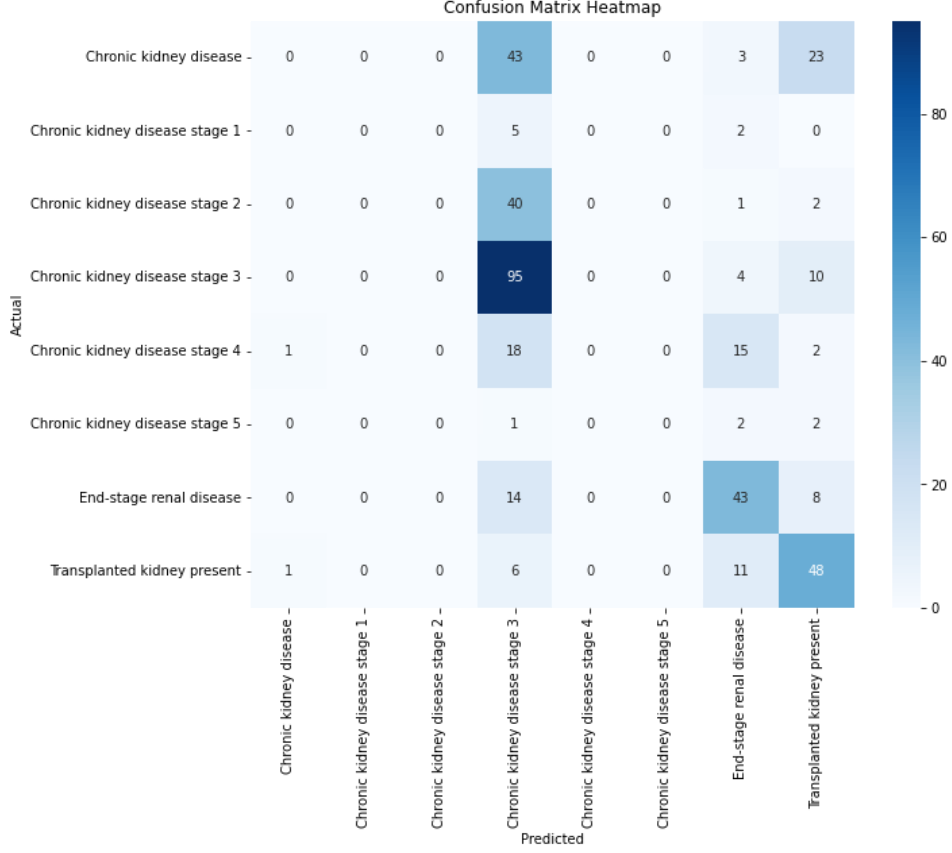

In [26]:
# result display (continued)
Image(filename='/content/螢幕擷取畫面 2024-04-06 184015.png')